In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from pathlib import Path

%reload_ext autoreload
%autoreload 2
import var_groups, build_frames, costs, descriptive_func

colors = [
    "#4C72B0",  # blue
    "#55A868",  # green
    "#C44E52",  # red-ish
    "#8172B3",  # purple
    "#CCB974",  # ochre
    "#64B5CD",  # light blue
    "#8C8C8C",  # grey
    "#E17C05",  # orange
    "#76B7B2",  # teal
    "#F1CE63",  # yellow
]

# Initial output for paper

I build a freamework that can easily compose key outputs from the analysis.

## 1. Decompositions

In [2]:
# 1. get data
dfs = [build_frames.timeseries_yearly(f) for f in var_groups.refs]
all_y = pd.concat(dfs, ignore_index=True)

In [3]:
source_labels = {
    Path(fname).stem: nice
    for fname, nice in var_groups.all_cases_dict.items()
}

### 1.1 Production decomposition (heat and electricity)

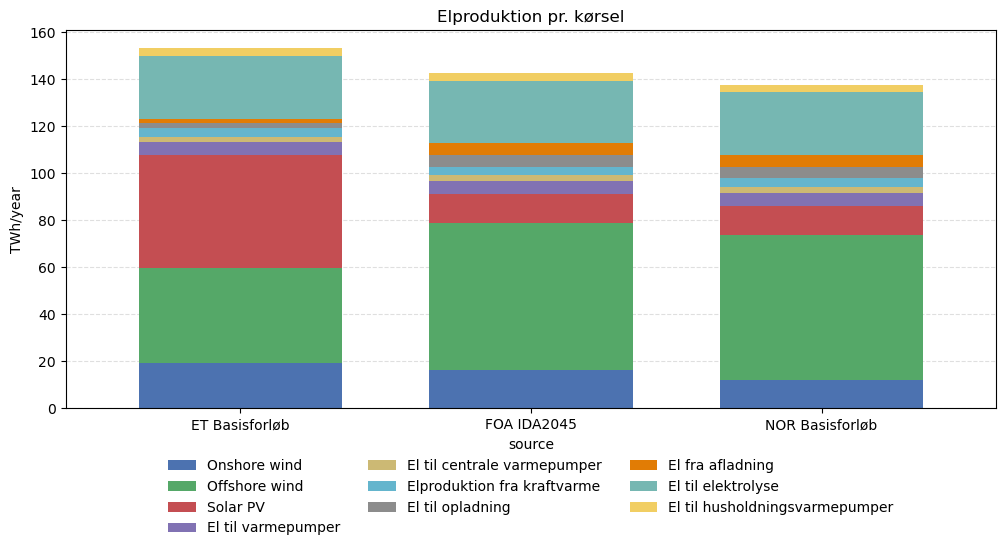

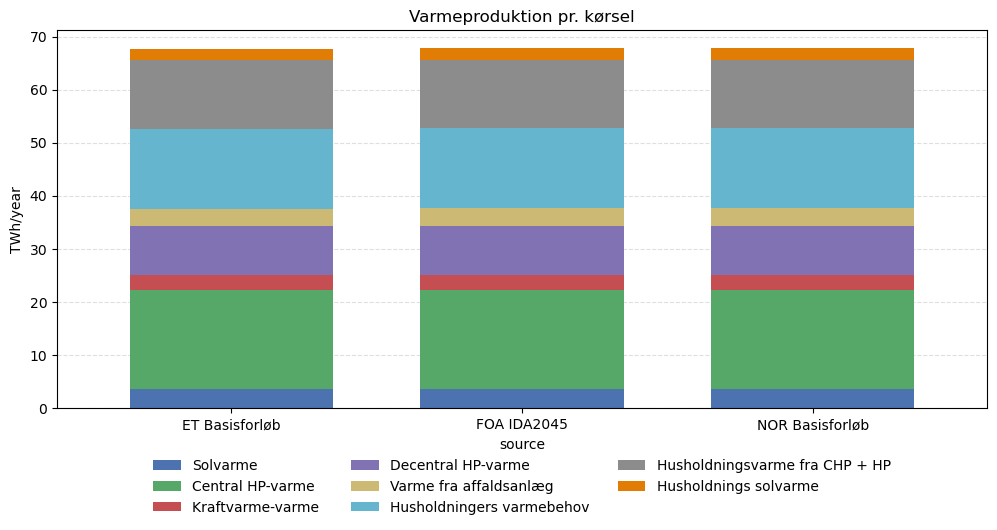

In [4]:
# 2. plot
fig, ax = descriptive_func.plot_stacked_by_source(
    demand_df=all_y.loc[:, var_groups.electr + ['source']],
    title="Elproduktion pr. kørsel",
    ylabel="TWh/year",
    colors=colors,
    legend_ncol=3,
    tech_labels=var_groups.tech_labels,
    source_labels=source_labels,
)

fig, ax = descriptive_func.plot_stacked_by_source(
    demand_df=all_y.loc[:, var_groups.heat + ['source']],
    title="Varmeproduktion pr. kørsel",
    ylabel="TWh/year",
    colors=colors,
    legend_ncol=3,
    tech_labels=var_groups.tech_labels,
    source_labels=source_labels,
)

## 2. Capture rates

Merging my hourly df with the prices I calculate the capture rates for the simulated year as

$$
\text{Capture rate}_t = \frac{p^{Pt}_t}{\bar{p}_t}
$$

where $Pt$ defines the power technology and $\bar{p}_t$ the average yearly price:

In [5]:
# 1. get data
dfs = [build_frames.timeseries_hourly(f) for f in var_groups.refs]
all_h = pd.concat(dfs, ignore_index=True)

In [6]:
# 2. relevant
keep_cols = var_groups.electr + ['source', 'd_summer', 'hour','InMarket_Prices']
col_mask = all_h.columns.isin(keep_cols)
electr_h = all_h.loc[:, col_mask].copy()

# 3. compute agg prod
electr_h['agg_prod'] = electr_h.loc[:, var_groups.electr].sum(axis=1)

# 4. average production price
def wavg(df, weight_col):
    w = df[weight_col]
    return np.average(df['InMarket_Prices'], weights=w)

# 4.1 full year
y_wavg = (
    electr_h
    .groupby('source')[['InMarket_Prices', 'agg_prod']]
    .apply(wavg, weight_col='agg_prod')
)
# 4.2 year and dummy
y_wavg_d = (
    electr_h
    .groupby(['source', 'd_summer'])[['InMarket_Prices', 'agg_prod']]
    .apply(wavg, weight_col='agg_prod')
)

# 5. prices per pt
pt_wavg, pt_wavg_d = [], []

for pt in var_groups.electr:
    # 5.1 full year
    pt_ = (
        electr_h
        .groupby('source')[['InMarket_Prices', pt]]
        .apply(wavg, weight_col=pt)
    )

    pt_.name = pt 
    pt_wavg.append(pt_)

    # 5.2 year and dummy
    pt_d = (
        electr_h
        .groupby(['source', 'd_summer'])[['InMarket_Prices', pt]]
        .apply(wavg, weight_col=pt)
    )
    pt_d.name = pt 
    pt_wavg_d.append(pt_d)
    
# 6. compute capture rates
pt_wavg_df   = pd.concat(pt_wavg, axis=1)
pt_wavg_d_df = pd.concat(pt_wavg_d, axis=1)

# 6.1 full year capture rate
capture_full = pt_wavg_df.div(y_wavg, axis=0)

# 6.2 seasonal capture rate (summer vs non-summer)
capture_seasonal = pt_wavg_d_df.div(y_wavg_d, axis=0)

##### *Plot:*

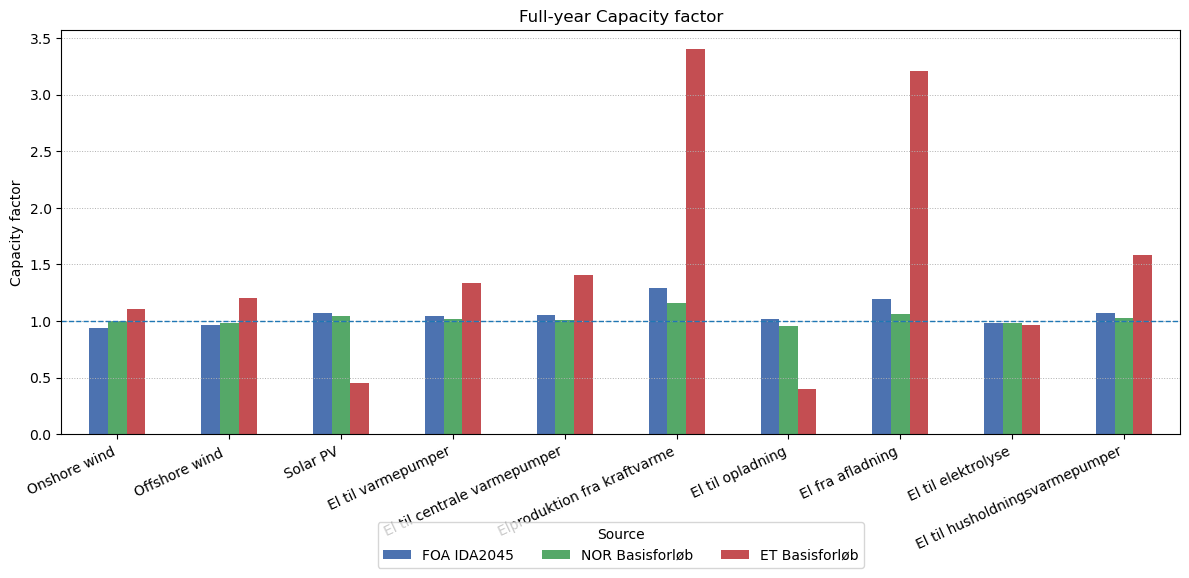

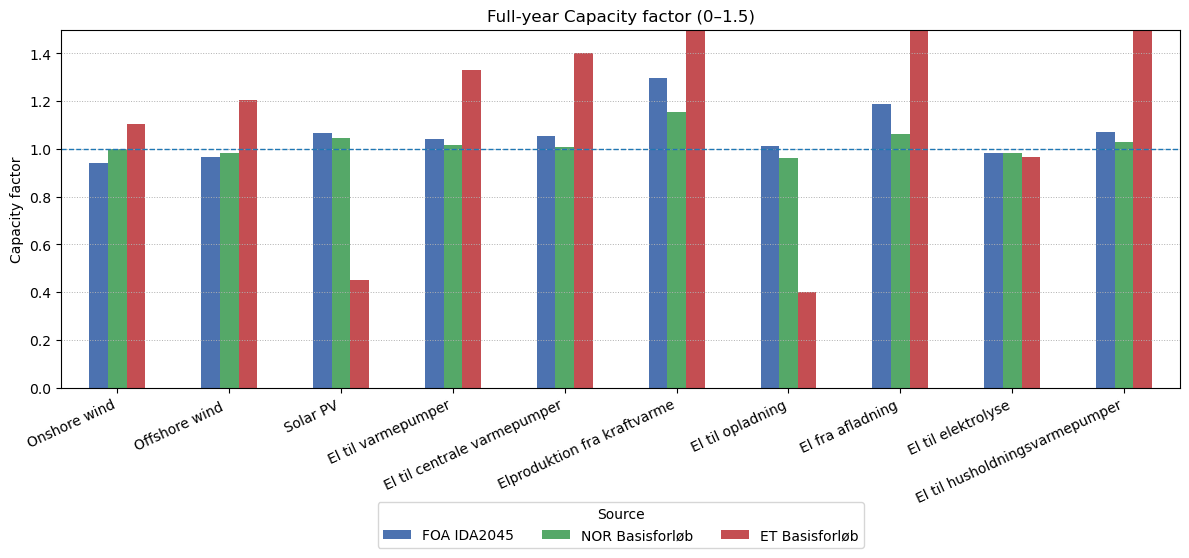

In [48]:
# 8a. plot yearly
capture_full_plot = capture_full.rename(columns=var_groups.tech_labels)
descriptive_func.plot_capture_full(capture_full_plot, source_labels=source_labels,colors=colors)

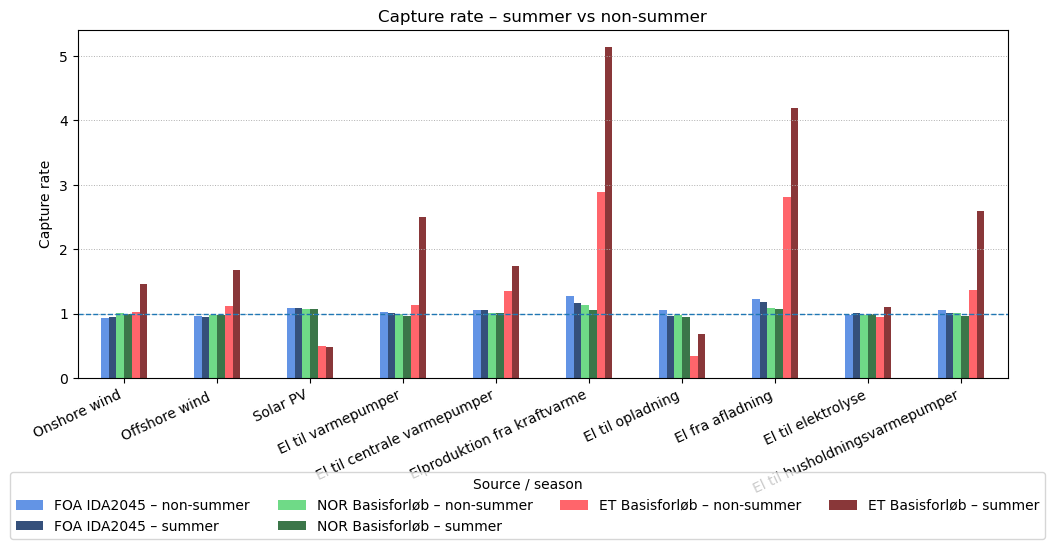

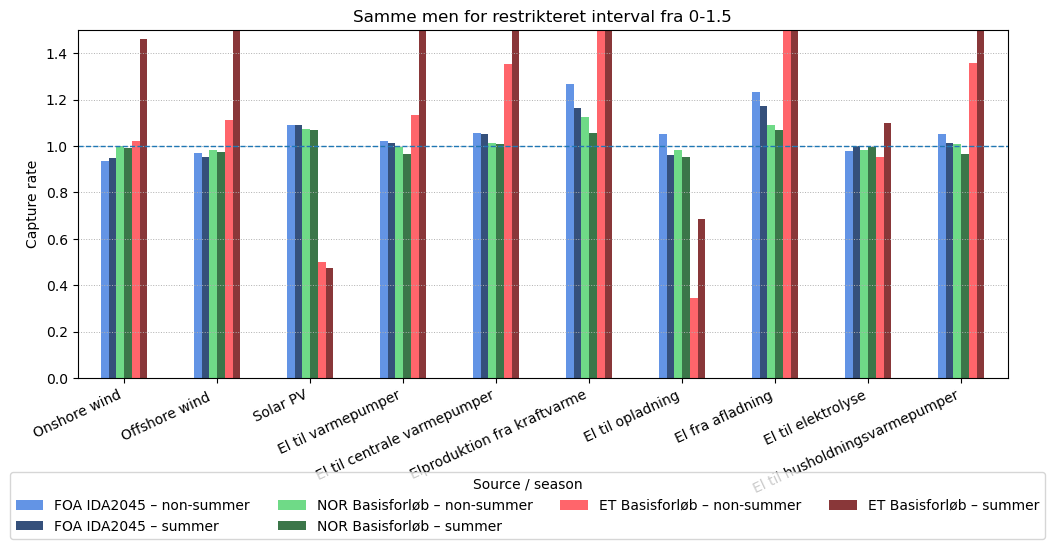

In [47]:
# 8b. plot after d_summer
capture_seasonal_plot = capture_seasonal.rename(columns=var_groups.tech_labels)
descriptive_func.plot_capture_seasonal(
    capture_seasonal_plot,
    source_labels=source_labels,
    colors_input=colors, 
)

## 3. Capacity factor

Similarly, I compute the capacity factor as

$$
    \text{Capacity factor}_t = \frac{\hat{y}_t^{Pt}}{y_t^{Pt}}
$$

with $\hat{y}_t^{Pt}$ as the actual production and $y_t$ as the technologically feasible:

In [53]:
# 1. get (using from #2)
keep_cols = var_groups.VE_electr + ['source', 'd_summer', 'hour']   # VE version
# keep_cols = var_groups.storages + ['source', 'd_summer', 'hour']   # storage version

col_mask = all_h.columns.isin(keep_cols)
VE_h = all_h.loc[:, col_mask].copy()

# 2. compute sums
pt_sum, pt_sum_d = [], []

for pt in var_groups.VE_electr:

    pt_y = VE_h.groupby('source')[pt].sum()
    pt_y.name = pt 
    pt_sum.append(pt_y)

    pt_y_d = VE_h.groupby(['source','d_summer'])[pt].sum()
    pt_y_d.name = pt 
    pt_sum_d.append(pt_y_d)

pt_sum_df   = pd.concat(pt_sum, axis=1)
pt_sum_d_df = pd.concat(pt_sum_d, axis=1)

# 3. get capacities
caps_by_source = {
    'R_1_nt':         var_groups.R_1_nt_caps,
    'RES':            var_groups.RES_caps,
    'IDA2045_Final':  var_groups.IDA2045_Final_caps,
}

# 4. make consistent and yearly
caps_df = pd.DataFrame.from_dict(caps_by_source, orient='index')
caps_df = caps_df[var_groups.VE_electr]
caps_df = caps_df.reindex(index=pt_sum_df.index)

cap_energy_full = caps_df * 8784  #* 1000

# 5. compute cap fac

# 5.1 full year
cf_full = pt_sum_df / cap_energy_full

# 5.2 d_summer
hours_d = (
    VE_h
    .groupby(['source', 'd_summer'])['hour']
    .nunique()
)

# 5.2.1 specific hours multi
caps_for_groups = caps_df.loc[
    pt_sum_d_df.index.get_level_values('source')
].to_numpy()
cap_energy_d = caps_for_groups * hours_d.to_numpy()[:, None]  #* 1000

# 5.2.2 df in same format
cap_energy_d_df = pd.DataFrame(
    cap_energy_d,
    index=pt_sum_d_df.index,
    columns=pt_sum_d_df.columns,
)

# 5.2.3 seasonal capacity factor
cf_seasonal = pt_sum_d_df / cap_energy_d_df

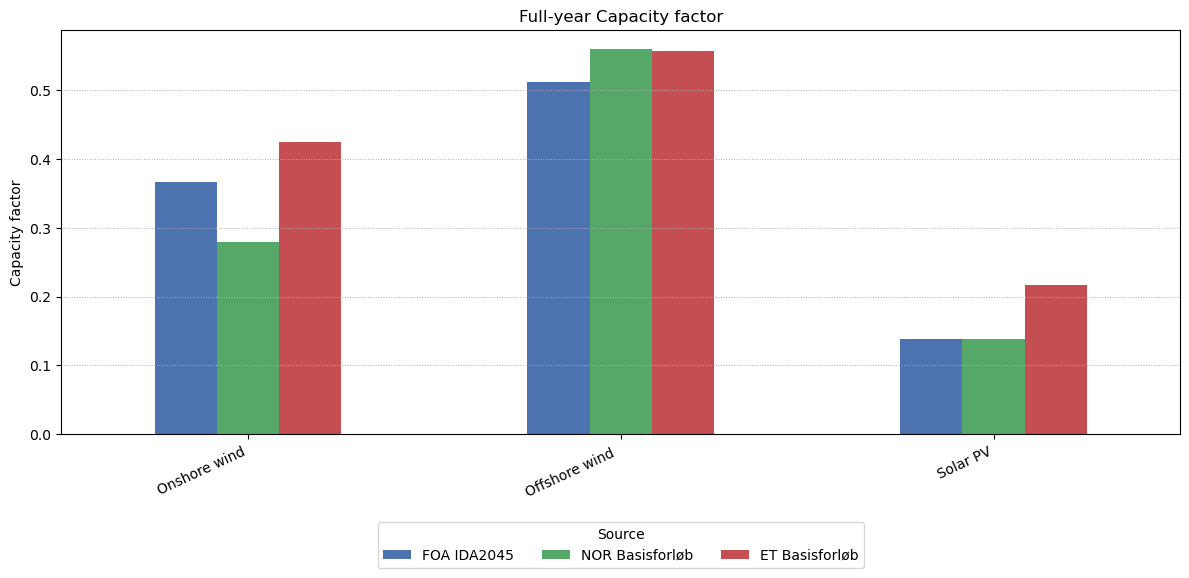

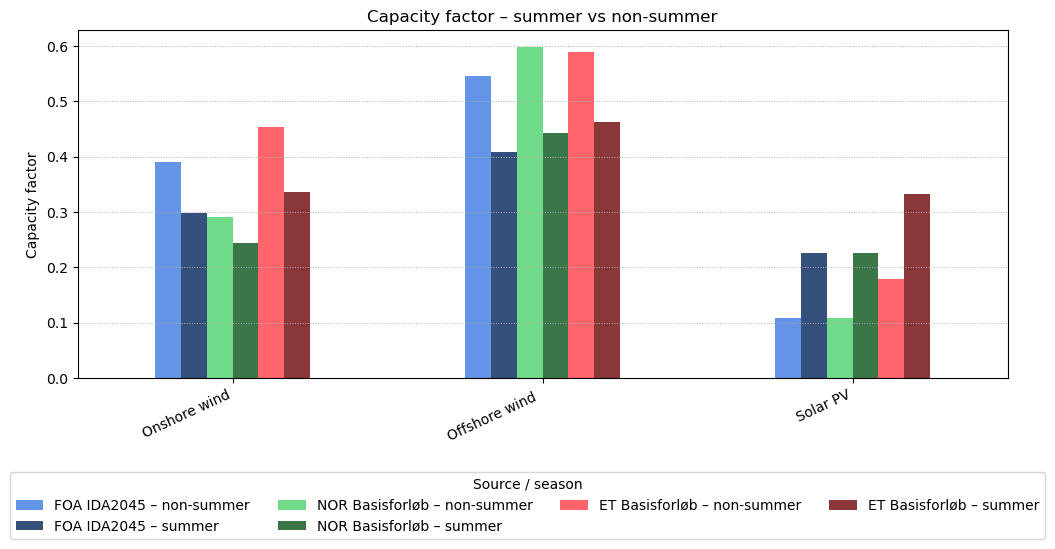

In [55]:
# full-year CF: one strong color per source (plot_capture_full)
cf_full_plot = cf_full.rename(columns=var_groups.tech_labels)
descriptive_func.plot_capture_full(
    cf_full_plot, 
    plot_two=False,
    source_labels=source_labels,
    colors=colors,
    axline=False
)

# seasonal CF: same shaded colours as before (plot_capture_seasonal)
cf_seasonal_plot = cf_seasonal.rename(columns=var_groups.tech_labels)
descriptive_func.plot_capture_seasonal(
    cf_seasonal_plot,
    source_labels=source_labels,
    colors_input=colors,
    plot_two=False,
    axline=False
)